Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 

1. Провести приоритизацию гипотез с помощью фреймворков ICE и RICE. Проанализировать инзменения.

2. Провести А/В тестирование.

3. Провести анализ А/В тестирования по следующим пунктам:

 -  Анализ графиков кумулятивной, выручки, среднего чека по грппам, количеству заказав на посетителям.
 -  Анализ относительных изменений.
 -  Анализ статичтической значимости различий.
 
 
4. Провести анализ результатов А/В тестирования.


# 1  Загрузим данные и подготовим их к анализу

Загрузим необходимые для исследования библиотеки

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import scipy.stats as stats
import datetime as dt

Присвоим соответствующие переменные данным о гипотезах, пользователях и заказах в соответсвующие переменные.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

Выгрузим первые пять строк каждой таблицы и информацию о них. Для каждой сделаем вывод.

In [3]:
display(hypothesis.head(5))
hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице hypothesis данные полные.

In [4]:
display(orders.head(5))
orders.info()


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В таблице orders данные полные, некорректно указан тип данных для колонки 'date'. В данной колонке указаны дата, а значит тип object некорректный. В дальнейшем изменим его.

In [5]:
display(visitors.head(5))
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В таблице visitors данные полные, некорректно указан тип данных для колонки 'date'. В данной колонке указаны даты, а значит тип object некорректный. В дальнейшем изменим его.

Проверим наличие дубликатов в таблицах

In [6]:
print(visitors.duplicated().sum())
print(orders.duplicated().sum())
print(hypothesis.duplicated().sum())

0
0
0


В данных нет дубликатов.

Проверим наличие пропущенных значений в таблицах.

In [7]:
print(visitors.isna().sum())
print(orders.isna().sum())
print(hypothesis.isna().sum())

date        0
group       0
visitors    0
dtype: int64
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


Пропущенных значений в данных нет.

Приведем данные к соответсвующему типу (даты)

In [8]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [9]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Просмотрим количество групп, выясним есть ли совпадения по группам( данная информация понадобится нам для проведения А/В эксперемента)

Просмотри количество групп:

In [10]:
visitors['group'].value_counts()

B    31
A    31
Name: group, dtype: int64

Проверим группы на наличие одинаковых пользователей в группе:

In [11]:
group_a = orders[orders['group'] == 'A']['visitorId']
group_b = orders[orders['group'] == 'B']['visitorId']
orders_ab = orders.query('visitorId in @group_a and visitorId in @group_b')
print('Количество пользователей в двух группах:', orders_ab['visitorId'].nunique())
print('Всего пользователей в тесте:', orders['visitorId'].nunique())

Количество пользователей в двух группах: 58
Всего пользователей в тесте: 1031


Выясним процент пользователей из двух групп от общего количества:

In [12]:
percent_ab=orders_ab['visitorId'].nunique()/orders['visitorId'].nunique()*100
print('Процент пользователей из двух групп от общего количества', percent_ab)

Процент пользователей из двух групп от общего количества 5.625606207565471


Выясним информацию о заказах пользователей

In [13]:
orders_ab['revenue'].describe()

count      181.000000
mean      8612.900552
std      14161.550845
min         50.000000
25%       1530.000000
50%       3460.000000
75%       8439.000000
max      93940.000000
Name: revenue, dtype: float64

Сделаем таблицу с пользователями и суммой их заказов

In [14]:
orders_ab.groupby('visitorId').agg({'transactionId':'count', 'revenue':'sum'}).sort_values('revenue', ascending=False)

,transactionId,revenue
visitorId,,
4256040402,11,176490
4266935830,2,157980
2378935119,9,142939
1316129916,2,94770
3062433592,5,75459
2458001652,11,62098
4120364173,2,55300
393266494,3,55290
3984495233,3,54933


Из анализа данных о группах пользователей и заказах мы получаем такие данные:

- 58 пользователей одновременно присутствуют в двух группах.
- Всего в таблице 1031 пользоватей
- Всего данные пользователи сделали 181 заказ.
- Средняя сумма заказа 8612.
- Максимальная сумма заказа 93940.
- Процент пользователей из групп А и В от общего числа пользователей 5,6%.

Вывод: Процент пользователей из двух групп маленький, для дальнейшего корректного проведения теста А/В, очистим таблицу от этих пользователей.


In [15]:
orders = orders.query('visitorId not in @orders_ab["visitorId"]')
print('Всего пользователей в тесте осталось:', orders['visitorId'].nunique())

Всего пользователей в тесте осталось: 973


Общий вывод: 

-У нас имеются три таблицы с данными (visitors,hypothesis, orders).

-Дубликатов и пропусков в данных нет.

-Типы данных приведены к корректному формату.

-Скорректированы данные по группам.

# 2 Приоритизация гипотез. (ICE и RICE)

С помощью фреймворка Ice приоритезируем гипотезы. Отсортируйем их по убыванию приоритета.

In [16]:
pd.set_option('display.max_colwidth', 500)
hypothesis['ICE'] = round((hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts'],1)
display(hypothesis[['Hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера v1:</b>
    
Можно для красоты округлить значение ICE.

<div class="alert alert-info"> <b>Исправлено
    </b> </div>


При приоретизации с помощью ICE топ-3 гипотезы: 

1) Запустить акцию, дающую скидку на товар в день рождения	

2) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	 

3) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

С помощью фреймворка RICE приоритезируем гипотезы. Отсортируйем их по убыванию приоритета. 

In [17]:
pd.set_option('display.max_colwidth', 500)
hypothesis['RICE'] = (hypothesis['Reach']  *hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
display(hypothesis[['RICE', 'Hypothesis']].sort_values(by='RICE', ascending=False))

,RICE,Hypothesis
7,112.0,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"
2,56.0,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"
0,40.0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей"
6,40.0,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию"
8,16.2,"Запустить акцию, дающую скидку на товар в день рождения"
3,9.0,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар"
1,4.0,"Запустить собственную службу доставки, что сократит срок доставки заказов"
5,4.0,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов"
4,3.0,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей"


При приоретизации с пмощью RICE топ-3 гипотезы: 

1) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа	

3) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Общий вывод:  
Наиболее перспективные гипотезы (ICE): 8, 0, 7. При расчете RICE порядок приоритетности изменился, наиболее перспективными оказались: 7, 2, 0, так как при расчете RICE учитываем как много пользователей затронет гипотеза.

# Анализ A/B-теста

Построение графика кумулятивной выручки по группам.Выводы и предположения.

Сбор данных.

In [18]:
groupDate = orders[['date','group']].drop_duplicates() #Создаем датафрейм с уникальными значениями "date" и "group" таблицы orders.
#Объявим пременную ordersAgg с датой, группой А/В теста, число уникальных пользователей,заказов и суммарную выручку поуказанную дату.
ordersAgg = groupDate.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transactionId' : pd.Series.nunique,
'visitorId' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
#Объявим переменную visitorsAgg с датой, группой А/В теста, количество уникальных посетителей  по указанную дату включительно.
visitorsAgg = groupDate.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])
#Определим переменную cumulativeData, объединив ordersAgg и visitorsAgg по колонкам 'date', 'group'
cumulativeData = ordersAgg.merge(visitorsAgg, left_on=['date', 'group'], right_on=['date', 'group'])
#Присвоим столбцам cumulativeData названия.
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
# Выведем полученную таблицу
display(cumulativeData.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Объявим переменные cumulativeRevenueA и cumulativeRevenueB, в которых сохраним данные о датах, выручке и числе заказов в группах A и B, затем построим график и сделаем вывод.

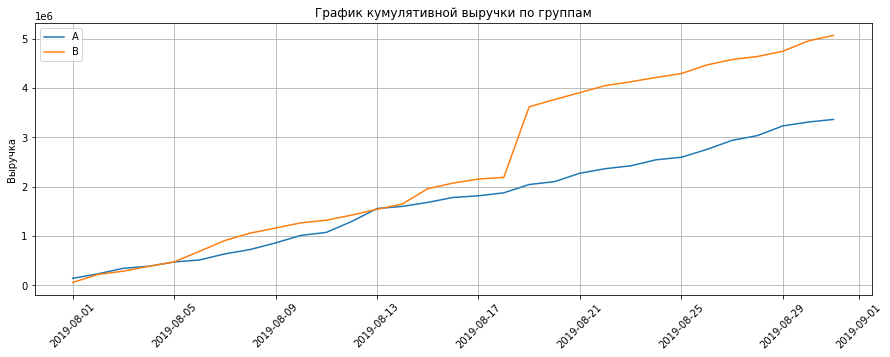

In [19]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('График кумулятивной выручки по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Вывод:

С начала августа по середину (13.08) выручка растет практически одинаково в двух группах (в группе В чуть быстрее). 13 августа выручка одинаковая у двух групп. С 13 августа выручка в группе В начнает резко увеличиваться  по сравнению с А. Основной скачок происходит после 17 августа. Такой резкий скачок может говорить о вбросах.Можно предположить, что  сильный всплеск выручки в группе B 17 августа может быть связан с крупным(-ми) заказом(-ами). Если отбросить его, то по графикам можно предположить, что выручки росли примерно одинаково, но у группы В она все равно выше на протяжении всего месяца.

Построение графика кумулятивного среднего чека по группам. Выводы и предположения.

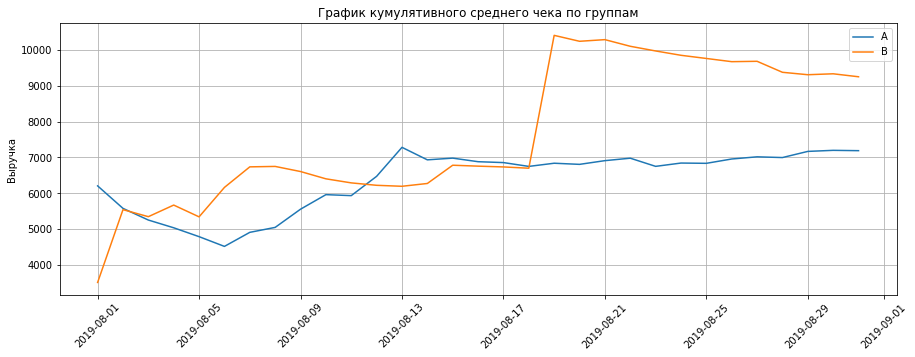

In [20]:
plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.title('График кумулятивного среднего чека по группам')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Вывод:
 Кумулятивное значение среднего чека по группам неравномерное. Есть резкие скачки и падения. 17 августа снова резкий скачок у группы В. Пердположительно крупные заказы. После 21 августа происходит постепенное снижение у группы В. Принимать решения по данной метрике рано и требуется анализ вбросов.
  Кумулятивное значение среднего чека по группе А в основном находится на одном уровне. Не считая резкого скачка 5 августа.

Построение графика относительного изменения кумулятивного среднего чека группы B к группе A. Выводы и предположения.

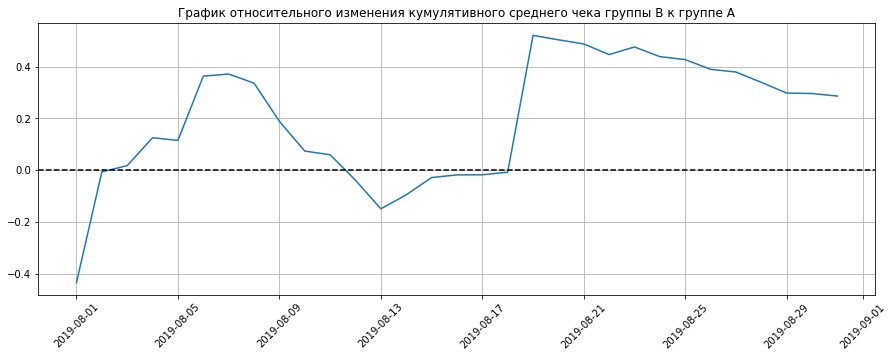

In [21]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeRevenue['date'],
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Вывод:

Результаты теста резко меняются в период с 5.08 по 9.08, а также с 17.08. В эти периоды, предположительно, совершены аномальные заказы.

Построение графика кумулятивного среднего количества заказов на посетителя по группам.Выводы и предположения.

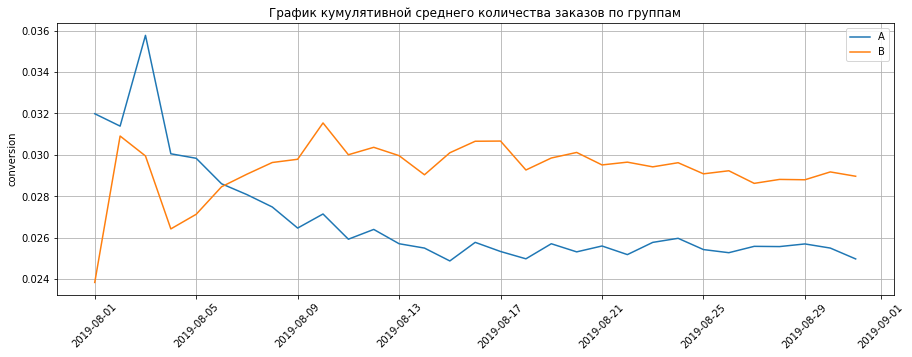

In [22]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors'] #cоотношение числа заказов к количеству пользователей в указанной группе в указанный день

#Переменные cumulativeDataA и cumulativeDataB, в которых сохраним данные о заказах в сегментах A и B соответственно
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной среднего количества заказов по группам')
plt.ylabel('сonversion')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

В начале теста группа А имела больщую конверсию, затем начала снижатся в период с 05.08 по 13.08 и затем держиться до конца периода практически на одном уровне. У группы В на графике видна обратная ситуация и значения выше сегмента А. При этом преиоды резких скачков и удержания значений на одном уровне, у двух групп, практически одинаковая.

Построение графика относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. Выводы и предположения.

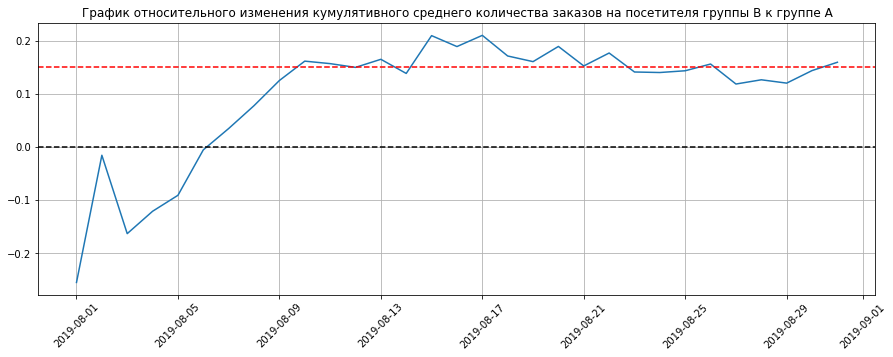

In [23]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B']
) #Объединим таблицы cumulativeDataA и cumulativeDataB, cохраним в переменной mergedCumulativeConversions

plt.figure(figsize=(15,5))
plt.plot(
    mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
    mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='red', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Кумулятивное среднее количество заказов на посетителя группы B растет относительно группы А.

Построение точечного графика количества заказов по пользователям. Выводы и предположения.

Создадим таблицу по заказам

In [24]:
visitors_orders = orders.groupby(
    'visitorId', as_index=False).agg({'transactionId':'nunique'}).rename(columns={'transactionId':'orders'}
)
visitors_orders.head()

,visitorId,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


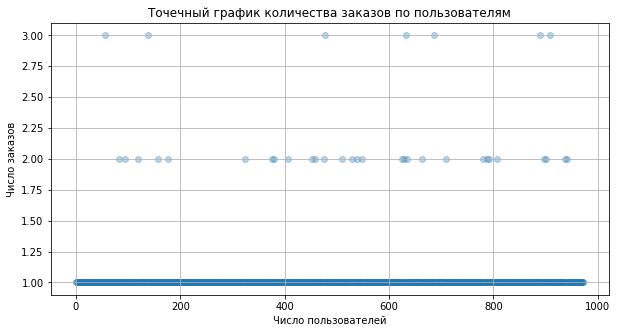

In [25]:
x_values = pd.Series(range(0,len(visitors_orders['orders'])))

plt.figure(figsize=(10,5))
plt.scatter(x_values, visitors_orders['orders'], alpha=0.3)
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Число заказов')
plt.grid()
plt.show()

Вывод: В основном пользователи совершают заказ один раз. Меньше пользователей совершают заказ 2, 3 раза.

Расчет 95-й и 99-й перцентили количества заказов на пользователя. Выбор граници для определения аномальных пользователей.

Расчет перцентали:

In [26]:
print('90 перцентиль:', (np.percentile(visitors_orders['orders'], [90])))
print('95 перцентиль:', (np.percentile(visitors_orders['orders'], [95])))
print('99 перцентиль:', (np.percentile(visitors_orders['orders'], [99])))

90 перцентиль: [1.]
95 перцентиль: [1.]
99 перцентиль: [2.]


Не более одного процента пользователей совершили более 2 заказов.

Выясним максимальное количество заказов.

In [27]:
print('Максимальное количество заказов:', visitors_orders['orders'].max())

Максимальное количество заказов: 3


Логично сделать максимальной границей по заказам - 2 заказа.

Количество пользователей за выбранной границей:

In [28]:
len(visitors_orders[visitors_orders['orders'] > 2]['visitorId'])

7

Вывод: Максимальной границей по заказам следует выбрать 2 заказа.

Построение точечного графика стоимости заказов. Выводы и предположения.

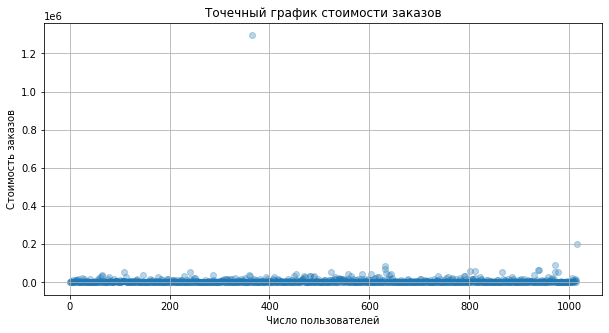

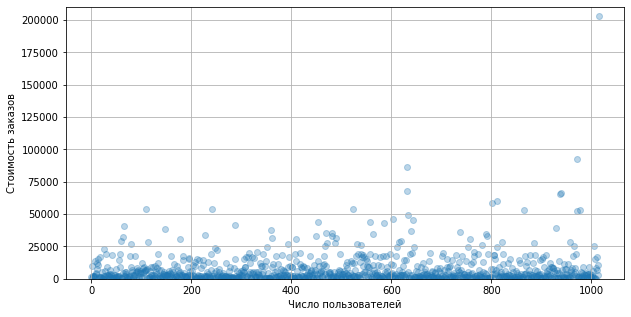

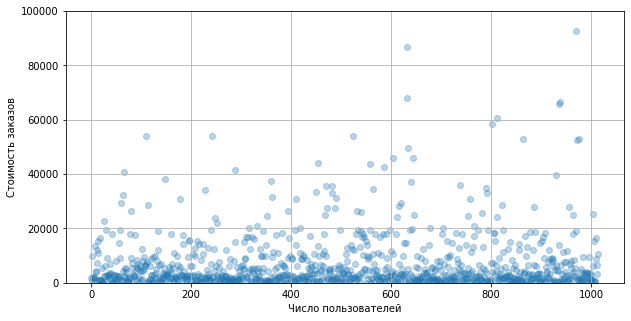

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], alpha=0.3)
plt.title('Точечный график стоимости заказов')
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], alpha=0.3)
plt.ylim(0, 210000)
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(x_values, orders['revenue'], alpha=0.3)
plt.ylim(0, 100000)
plt.xlabel('Число пользователей')
plt.ylabel('Стоимость заказов')
plt.grid()
plt.show()

На основном графике виден очевидный вброс на уровне 1.2 (слишком большая стоимость заказа). В основном все заказы сосредоточены до стоимости 100000. Возьмем для работы данные не превышающие этой стоимости.

Расчет 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [30]:
print('90 перцентиль:', (np.percentile(orders['revenue'], [90])))
print('95 перцентиль:', (np.percentile(orders['revenue'], [95])))
print('99 перцентиль:', (np.percentile(orders['revenue'], [99])))

90 перцентиль: [17990.]
95 перцентиль: [26785.]
99 перцентиль: [53904.]


Не более 5% пользователей совершили заказ на сумму больше 26785.
Не более 1% пользователей совершили заказ на сумму больше 53904. Аномальными будем считать заказы на сумму больше этого значения.

Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным.Выводы и предположения.

In [31]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

cummulative = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Сформулируем гипотезы:

Нулевая гипотеза: Среднее количество заказов между группами А и В равно.( Между выборками нет статистической значимости, либо она незначительна.)
Альтернативная гипотеза: Среднее количество заказов между группами А и В различается. (Между выборками имеется статистическая значимость.)
Применим критерием Манна-Уитни. Порогом статистической значимости установим alpha = 0.05

In [32]:
print('p-value нулевой гипотезы:', '{0:.9f}'.format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('p-value альтернативной гипотезы:', '{0:.9f}'.format(sampleB.mean() / sampleA.mean() - 1))

p-value нулевой гипотезы: 0.011018084
p-value альтернативной гипотезы: 0.159797792


P-value значительно меньше 0.05, не получилось подтвердить нулевую гипотезу.Среднее количество заказов между группами А и В различается. Альтернативная гипотеза подтвердилась.

Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным. Выводы и предположения.

Сформулируем гипотезы:

Нулевая гипотеза: Средний чек в группе A равен группе B (статистическая значимость не значительна и сделать вывод о различии нельзя)
Альтернативная гипотеза: Средний чек в группе A не равен группе B (между выборками имеется статистическая значимость)
Применим критерием Манна-Уитни. Порогом статистической значимости установим alpha = 0.05

In [33]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.829
0.287


P-value значительно больше 0.05, не получилось отвергнуть нулевую гипотезу. Средний чек в группе A равен группе B .
Относительный прирост среднего чека группы В к группе А равен 28,7%. Что было заметно на графиках ранее.

Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. Вывод и предположения.

Подготовка данных


Ранее в исследовании, мы получили такие данные:
- 95-й и 99-й перцентили стоимости заказов равны 26785 и 53904 рублям. 
- 95-й и 99-й перцентили числа заказов на одного пользователя равны 1 и 2 заказам на пользователя. 

Примем за аномальных пользователей тех, кто совершил более 2 заказов или совершил заказ на сумму свыше 53904 рублей для того, чтобы уберать 1% пользователей с наибольшим числом заказов и с наибольшей стоимостью.

In [34]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(visitors_orders['orders'], [99]))]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(visitors_orders['orders'], [99]))]['userId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [99]))]['visitorId']
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                cummulative['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Сформулируем гипотезы:

Нулевая гипотеза: Среднее количество заказов на посетителя между группами  A и B равна(статистическая значимость не значительна и сделать вывод о различии нельзя)
Альтернативная гипотеза: Среднее количество заказов на посетителя  в группе A не равна группе B (между выборками имеется статистическая значимость)
Применим критерием Манна-Уитни. Порогом статистической значимости установим alpha = 0.05

In [35]:
print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
0.189


P-value значительно меньше 0.05, отвергаем нулевую гипотезу. Среднее количество заказов на посетителя  в группе A не равна группе B (между выборками имеется статистическая значимость)
Относительный прирост среднего количество заказов на посетителя группы В к группе А равен 18,9%. Изменение по сравнению с прошлыми результатами почти 3%.
Подтвердилась та же гипотеза.

Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным. Выводы и предположения.

Сформулируем гипотезы:

Нулевая гипотеза: Средний чек в группе A равен группе B (статистическая значимость не значительна и сделать вывод о различии нельзя)
Альтернативная гипотеза: Средний чек в группе A не равен группе B (между выборками имеется статистическая значимость)
Применим критерием Манна-Уитни. Порогом статистической значимости установим alpha = 0.05

In [36]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    '{0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.788
-0.032


P-value значительно больше 0.05, не получилось отвергнуть нулевую гипотезу. Средний чек в группе A равен группе B (статистическая значимость не значительна и сделать вывод о различии нельзя).
Относительное снижение среднего чека группы В к группе А примерно равен 3%. Изменение по сравнению с прошлыми результатами почти 30%.
Подтвердилась та же гипотеза.

# Принятие решения по тестированию

Тест можно остановить и считать успешно пройденным.

Среднее количество заказов на посетителя  в группе A не равно группе B (между выборками имеется статистическая значимость) по сырым и по очищенным данным.

Средний чек в группе A равен группе B (статистическая значимость не значительна и сделать вывод о различии нельзя) по сырым и по очищенным данным.

В ходе анализа выяснили, что группа В показывает результаты по средним количествам заказов на посетителя, чем группа А.
Среднемий чек не имеет значимых различий между группами.